step 23: all PSG features are concatenated and standatrized without artifacts. Furthermore, PCA with 50 components and K-Means clustering are applied. The distribution of K-Means clusters are stored in csv file.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter as counter
import seaborn as sns
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.svm import SVC

%matplotlib inline

In [5]:
no_subject = 27 # number of subjects
no_channel = 12 # number of channels
no_columns = 234 # total number of columns per night

file_path = './PSG_features/' # features files path
data = pd.read_csv('PSG_features_12chn.csv') # features files names
file_name = data['fname']
y = pd.read_csv('PSG_dataset.csv')['label']

shape of one subject having 8 channels: (954, 234)


0.2046776959020358

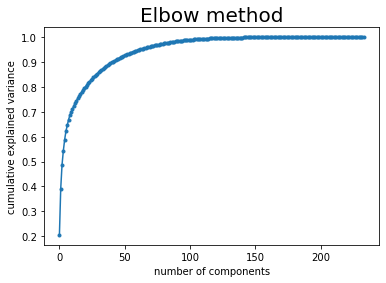

In [6]:
sub_len = pd.read_csv(file_path+file_name[0]).shape  # features data shape
data_con = np.empty((sub_len[0],0)) # array for merging the PSG channels (subject) per night
column = np.empty((0))

for nchn in range(no_channel):
    df_feat = pd.read_csv(file_path+file_name[nchn])
    if 'alpha_mean' in df_feat.columns:
        #df_feat = df_feat[df_feat['flag'] == 0]
        df_feat = df_feat.drop(df_feat[['flag', 'alpha_mean', 'theta_mean', 'delta_mean', 'label']], axis=1)# removing columns from EEG channels
        column = np.append(column, df_feat.columns)
        
    elif 'flag' in df_feat.columns:
        #df_feat = df_feat[df_feat['flag'] == 0]
        df_feat = df_feat.drop(df_feat[['mean', 'label', 'flag']], axis=1)# removing columns from EEG channels
        column = np.append(column, df_feat.columns)            
    else:
        df_feat = df_feat.drop(df_feat[['label', 'mean']], axis=1)  # removing columns from other PSG channels
        column = np.append(column, df_feat.columns)

    data_con = np.concatenate((data_con, df_feat), axis=1)
    
df = pd.DataFrame(data = data_con, columns=column)
print('shape of one subject having 8 channels: {}' .format(df.shape))

df['flag'] = pd.read_csv(file_path+file_name[0])['flag'] 
df_feat = df[df['flag'] == 0] # removing atrifacts by single PSG channel's flag
X = df_feat.drop(['flag'], axis=1)
X_scalar = StandardScaler().fit_transform(X)
X_pca = PCA()
X_pca.fit_transform(X_scalar)

plt.plot(np.cumsum(X_pca.explained_variance_ratio_), '.-')
plt.title('Elbow method', fontsize=20)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
np.max(X_pca.explained_variance_ratio_)

In [7]:
X_pca = PCA(n_components=70).fit_transform(X_scalar)
distance = []
for i in range(1,10):
    kmeans_ = KMeans(i)
    kmeans_.fit(X_pca)
    distance.append(kmeans_.inertia_)
    
%matplotlib inline
plt.plot(np.arange(1,10), distance)
plt.title('Elbow method using inertia', fontsize=20)
plt.xlabel('number of clusters')
plt.ylabel('within-cluster sum-of-squares')

Text(0, 0.5, 'within-cluster sum-of-squares')

In [72]:
nfile = 0 # counter for the PSG file selecting
file_sel = 0 # counter for assigning the shape of an array
flag_col = -6 # counter of selection of feature file for artifact removing (flag)
n_cluster = 4

X_agg = np.empty((0, no_columns))
dist_array = np.empty((0, n_cluster))

for nsub in range(no_subject):
    sub_len = pd.read_csv(file_path+file_name[file_sel]).shape
    data_con = np.empty((sub_len[0],0))
    
    mean_array = np.empty((0))
    column = np.empty((0))
    file_sel += no_channel
    flag_col += no_channel # for EOG channel's flag
    
    for nchn in range(no_channel):
        df_feature = pd.read_csv(file_path+file_name[nfile])
        
        if 'alpha_mean' in df_feature.columns:
            df_feat = df_feature.drop(df_feature[['flag', 'alpha_mean', 'theta_mean', 'delta_mean', 'label']], axis=1) # removing columns from EEG channels
            column = np.append(column, df_feat.columns)
            
        elif 'flag' in df_feature.columns:
            df_feat = df_feature.drop(df_feature[['flag', 'label', 'mean']], axis=1) # removing columns from other PSG channels
            column = np.append(column, df_feat.columns)
            
        else:
            df_feat = df_feature.drop(df_feature[['label', 'mean']], axis=1) # removing columns from other PSG channels
            column = np.append(column, df_feat.columns)
            
        data_con = np.concatenate((data_con, df_feat), axis=1)
        nfile += 1
        
    df = pd.DataFrame(data = data_con, columns=column)
    df['flag'] = pd.read_csv(file_path+file_name[flag_col])['flag']
    df_feat = df[df['flag'] == 0]
    df_feat = df_feat.drop(['flag'], axis=1)
    
    X_scalar = StandardScaler().fit_transform(df_feat)
    X_pca = PCA(n_components=75).fit_transform(X_scalar)
    model = KMeans(n_clusters=n_cluster, random_state=1).fit(X_pca)
    
    dist = pd.crosstab(index='counts', columns=model.labels_)
    dist_array = np.concatenate((dist_array, dist), axis=0)
    
df_dist = pd.DataFrame(data=dist_array, columns=['cluster1', 'cluster2', 'cluster3', 'cluster4'])#, 'cluster5', 'cluster6'])

In [73]:
# calculating the cluster's proportion
dist_prop = np.empty((0, n_cluster))

for i in range(no_subject):
    dist_int = np.empty((0))
    dist_sum = np.sum(df_dist.iloc[i,:])
    
    for j in range(n_cluster):
        proportion = (df_dist.iloc[i,j]/dist_sum)*100
        dist_int = np.append(dist_int, [proportion], axis=0)

    dist_prop = np.append(dist_prop, [dist_int], axis=0)

In [74]:
# creating the dataframe of clusters, their proportion and true labels 
df_psg = pd.read_csv('PSG_dataset.csv') # for label and file
df_dist['clust1_proportion(%)'] = dist_prop[:,0]
df_dist['clust2_proportion(%)'] = dist_prop[:,1]
df_dist['clust3_proportion(%)'] = dist_prop[:,2]
#df_dist['clust4_proportion(%)'] = dist_prop[:,3]
df_dist[['fname', 'label']] = df_psg[['fname', 'label']]
df_dist.head()

cluster1  cluster2  cluster3  cluster4  clust1_proportion(%)  \
0      69.0     407.0     473.0       2.0              7.255521   
1      99.0     486.0     105.0     268.0             10.334029   
2     329.0     534.0      41.0      90.0             33.098592   
3     523.0      22.0     266.0     123.0             55.995717   
4     277.0     600.0      32.0     144.0             26.305793   

   clust2_proportion(%)  clust3_proportion(%)         fname  label  
0             42.797056             49.737119  A0000724.edf      0  
1             50.730689             10.960334  A0000737.edf      0  
2             53.722334              4.124748  A0000773.edf      0  
3              2.355460             28.479657  A0000934.edf      1  
4             56.980057              3.038936  A0000960.edf      1

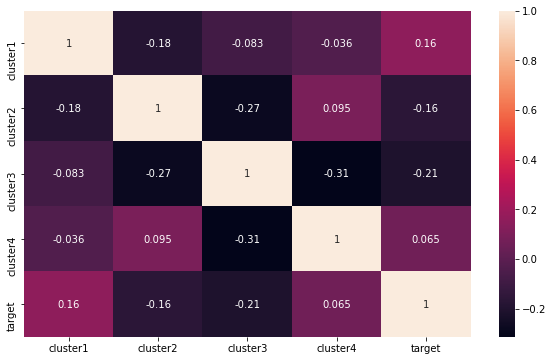

In [75]:
X_df = df_dist[['cluster1', 'cluster2', 'cluster3', 'cluster4']]#, 'cluster5', 'cluster6']]
y = df_dist['label']
X = StandardScaler().fit_transform(X_df)
df_p = pd.DataFrame(data=X, columns=['cluster1', 'cluster2', 'cluster3', 'cluster4'])#, 'cluster5', 'cluster6'])
df_p['target'] = y
plt.figure(figsize=(10,6))
sns.heatmap(df_p.corr(), annot=True)

In [76]:
# another dataset
df_l = pd.read_csv('large_dataset_predictors/PSG12_4_Clustering(75PC).csv') 
X_l = df_l[['cluster1', 'cluster2', 'cluster3', 'cluster4']]#, 'cluster5', 'cluster6']]
y_l = df_l['label']

In [77]:
X_merg = np.concatenate((X, X_l), axis=0)
y_merg = np.concatenate((y, y_l))
print('shape of merged data {} and their target labels {}' .format(X_merg.shape, y_merg.shape))

shape of merged data (59, 4) and their target labels (59,)


In [78]:
X_train, X_test, y_train, y_test = train_test_split(X_merg, y_merg, test_size=0.10, random_state=42)

In [79]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [80]:
predicted = model.predict(X_test)
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.67      1.00      0.80         4

    accuracy                           0.67         6
   macro avg       0.33      0.50      0.40         6
weighted avg       0.44      0.67      0.53         6

[[0 2]
 [0 4]]


In [81]:
predicted = model.predict(X_train)
print(classification_report(y_train, predicted))
print(confusion_matrix(y_train, predicted))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.69      0.97      0.81        37

    accuracy                           0.68        53
   macro avg       0.35      0.49      0.40        53
weighted avg       0.48      0.68      0.56        53

[[ 0 16]
 [ 1 36]]


In [82]:
model.coef_

array([[-0.00084989,  0.00264067,  0.00070792, -0.00144918]])

In [83]:
k_fold = KFold(n_splits=10)
accuracy_array = []

LR = LogisticRegression(random_state=0)
for k, (train, test) in enumerate(k_fold.split(X_merg, y_merg)):
    LR.fit(X_merg[train], y_merg[train])
    accuracy_array.append(LR.score(X_merg[test], y_merg[test]))
    print('cross validation fold {} result: {}' .format(k, LR.score(X_merg[test], y_merg[test])))
print('\n')
print('average accuracy of K-fold: {}' .format(np.mean(accuracy_array)))

cross validation fold 0 result: 0.5
cross validation fold 1 result: 0.5
cross validation fold 2 result: 1.0
cross validation fold 3 result: 1.0
cross validation fold 4 result: 0.3333333333333333
cross validation fold 5 result: 0.6666666666666666
cross validation fold 6 result: 0.5
cross validation fold 7 result: 0.5
cross validation fold 8 result: 0.5
cross validation fold 9 result: 0.8


average accuracy of K-fold: 0.63


In [84]:
accuracy_average = []
loo = LeaveOneOut()
loo.get_n_splits(X_merg)
i = 0

for train, test in loo.split(X_merg):
    
    LR.fit(X_merg[train], y_merg[train])
    accuracy_average.append(LR.score(X_merg[test], y_merg[test]))
    #print('cross validation fold {} result: {}' .format(i, LR.score(X_merg[test], y_merg[test])))
    i += 1
    
print('\naverage accuracy of one leave out CV: {}' .format(np.mean(accuracy_average)))

warnings.filterwarnings('ignore', category=UserWarning, append=True)


average accuracy of one leave out CV: 0.6440677966101694


In [56]:
# checking accuracy of trained model with 32 subjects (another dataset) features

df_l = pd.read_csv('large_dataset_predictors/PSG12_3_Clustering(70PC).csv') 
X_l = df_l[['cluster1', 'cluster2', 'cluster3']]
y_l = df_l['label']

In [19]:
# checking accuracy of trained model with 32 subjects (another dataset) features

predicted = model.predict(X_l)
print(classification_report(y_l, predicted))
print('ROC results: {}'.format(roc_auc_score(y_l, predicted)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.72      1.00      0.84        23

    accuracy                           0.72        32
   macro avg       0.36      0.50      0.42        32
weighted avg       0.52      0.72      0.60        32

ROC results: 0.5


Applying support vector machine estimator

In [20]:
# https://towardsdatascience.com/svm-hyper-parameter-tuning-using-gridsearchcv-49c0bc55ce29

param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001], 'kernel': ['rbf', 'poly', 'sigmoid']}
              
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(SVC(), param_grid, refit=True)
#grid.fit(X_train,y_train)

In [21]:
print(grid.best_estimator_)

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [85]:
svm = SVC(C=1, gamma=1, kernel='rbf', random_state=0)
svm.fit(X_train, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [86]:
predictions = svm.predict(X_train)
print(classification_report(y_train, predictions))

              precision    recall  f1-score   support

           0       1.00      0.56      0.72        16
           1       0.84      1.00      0.91        37

    accuracy                           0.87        53
   macro avg       0.92      0.78      0.82        53
weighted avg       0.89      0.87      0.86        53



In [96]:
k_fold = KFold(n_splits=10, random_state=1)
accuracy_array = []

SVM = SVC(C=1, gamma=0.01, kernel='rbf', random_state=0)
for k, (train, test) in enumerate(k_fold.split(X_merg, y_merg)):
    SVM.fit(X_merg[train], y_merg[train])
    accuracy_array.append(SVM.score(X_merg[test], y_merg[test]))
    print('cross validation fold {} result: {}' .format(k, SVM.score(X_merg[test], y_merg[test])))
    
print('\naverage accuracy of 10-fold: {}' .format(np.mean(accuracy_array)))

cross validation fold 0 result: 0.5
cross validation fold 1 result: 0.5
cross validation fold 2 result: 1.0
cross validation fold 3 result: 1.0
cross validation fold 4 result: 0.5
cross validation fold 5 result: 0.6666666666666666
cross validation fold 6 result: 0.8333333333333334
cross validation fold 7 result: 0.5
cross validation fold 8 result: 0.6666666666666666
cross validation fold 9 result: 0.8

average accuracy of 10-fold: 0.6966666666666667


C:\Users\Shahzeb\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [98]:
accuracy_array = []
loo = LeaveOneOut()
loo.get_n_splits(X)
i = 0

SVM = SVC(C=10, gamma=0.001, kernel='rbf', random_state=0)
for train, test in loo.split(X_merg):
    SVM.fit(X_merg[train], y_merg[train])
    accuracy_array.append(SVM.score(X_merg[test], y_merg[test]))
    #print('cross validation fold {} result: {}' .format(i, SVM.score(X_merg[test], y_merg[test])))
    i += 1
print('\naverage accuracy of one leave out CV: {}' .format(np.mean(accuracy_array)))

warnings.filterwarnings('ignore', category=UserWarning, append=True)


average accuracy of one leave out CV: 0.6949152542372882


In [ ]:
# checking accuracy of trained model with 32 subjects (another dataset) features

predicted = svm.predict(X_l)
print(classification_report(y_l, predicted))
print('ROC results: {}'.format(roc_auc_score(y_l, predicted)))